# Implementation 2: SARIMAX Model

## Justification
 - I decided to use the traditional ARIMA model because of its simplicity.
 - An alternative would have been to explore the use of ARIMAX with exogenous variables to add greater information into the model but this complexity introduces the risk of overfitting and may violate the risk of non-stationarity.
 - This assumption of stationarity is deemed crucial for ARIMA time series models and thus, I believe that a simplier model that accounts for the appropriate parameters would be not only less complex but may also prove to be more robust

# 1. Data Collection
 - As such, this implementation will only use the closing price of NVDA to predict for the price movement.

In [1]:
# imports for data manipulations
import pandas as pd
import numpy as np

# imports for visualisation
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline

# imports for yahoo finance
import yfinance as yf

# For time stamps
import datetime

In [2]:
# we will use the all of NVDA stock price
start_date = datetime.datetime(1999, 1, 22)
end_date = datetime.datetime.today()
nvda = yf.download(tickers = "NVDA", start=start_date, end=end_date)

[*********************100%%**********************]  1 of 1 completed


In [3]:
data_arima = nvda

# 2. Stationarity and Seasonality
* We will perform tests on the data to check for stationarity
* this is comprised of a visual plot, an ADF test and ACF + PACF plot
* this will also help me identify the p, d and q

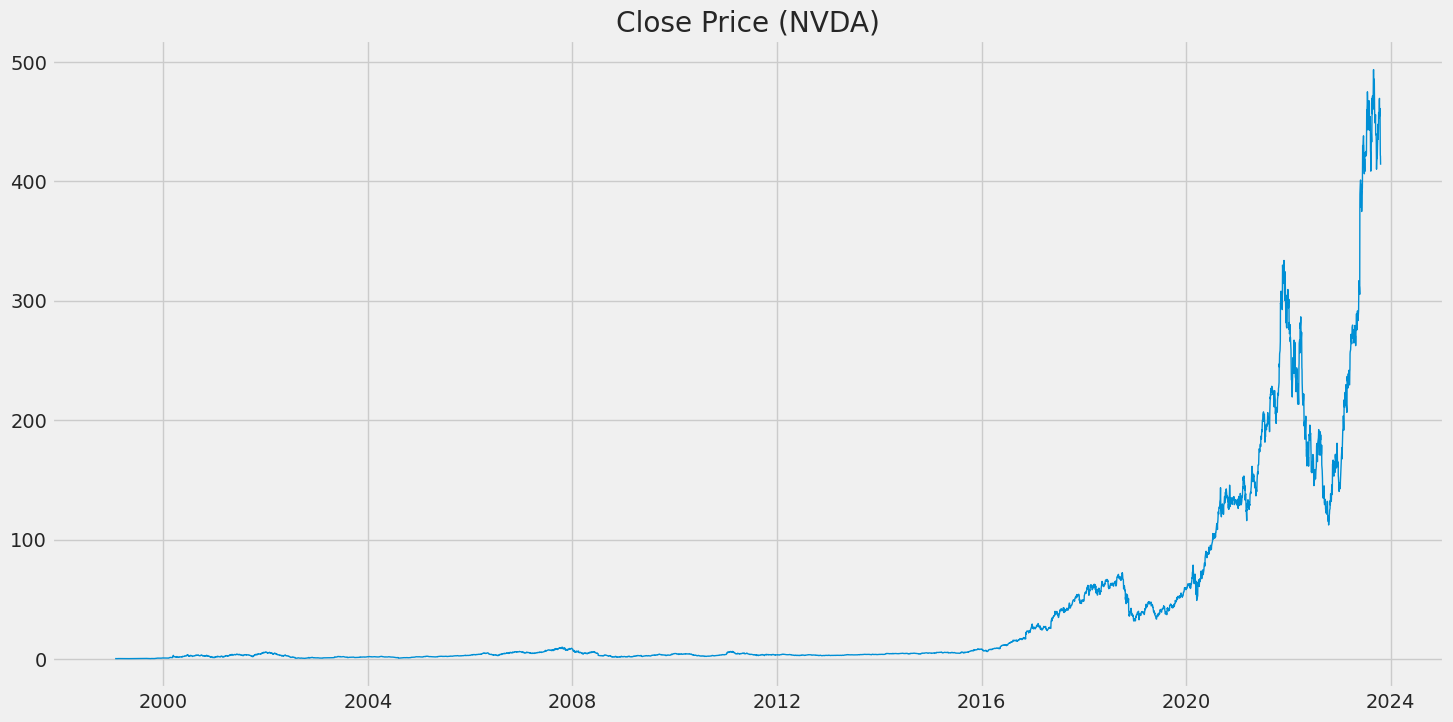

In [4]:
from statsmodels.tsa.stattools import adfuller

## we first plot the time series data to perform a visual check for trend and seasonality
plt.figure(figsize=(16, 8))
plt.plot(data_arima['Close'], linewidth = 1)
plt.title('Close Price (NVDA)')
plt.show()

In [5]:
## we then perform the Dickey-Fuller Test for stationarity
result = adfuller(data_arima['Close'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])
if result[1] <= 0.05:
    print('The data is stationary.')
else:
    print('The data is not stationary.')

ADF Statistic: 0.6465483175620742
p-value: 0.9887085015993929
Critical Values: {'1%': -3.431406355974594, '5%': -2.8620068149070077, '10%': -2.5670184827348006}
The data is not stationary.


* we will also use the ACF plot to check for stationarity
* the tests show that the closing price of NVDA is non-stationary, we will then use differencing to reduce variance

<Figure size 1600x800 with 0 Axes>

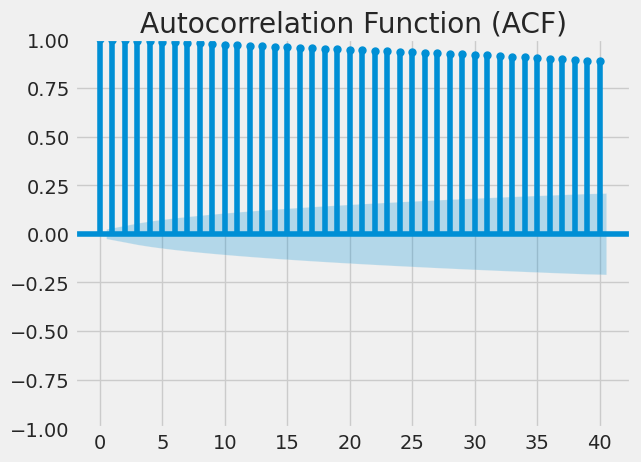

In [6]:
from statsmodels.graphics.tsaplots import plot_acf

plt.figure(figsize=(16, 8))
plot_acf(data_arima['Close'].dropna(), lags=40)
plt.title('Autocorrelation Function (ACF)')
plt.show()

<Figure size 1600x800 with 0 Axes>

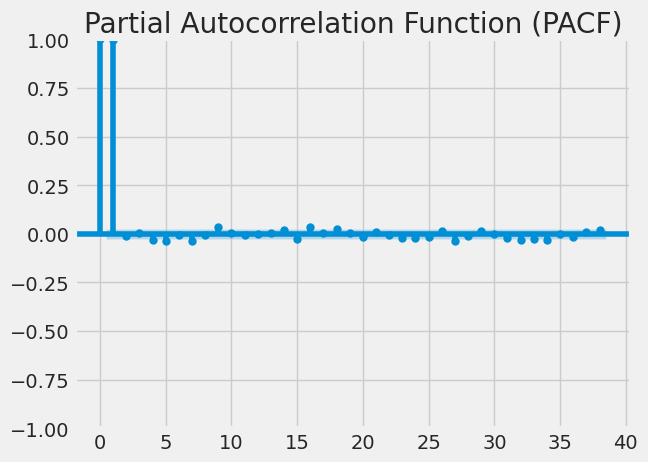

In [7]:
from statsmodels.graphics.tsaplots import plot_pacf

# Create the PACF plot
plt.figure(figsize=(16, 8))
plot_pacf(data_arima['Close'])
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

## Checking for seasonality and trends
 * We use the seasonal_decompose from statsmodels.tsa.seasonal to visualise clearly te seasonality and trends

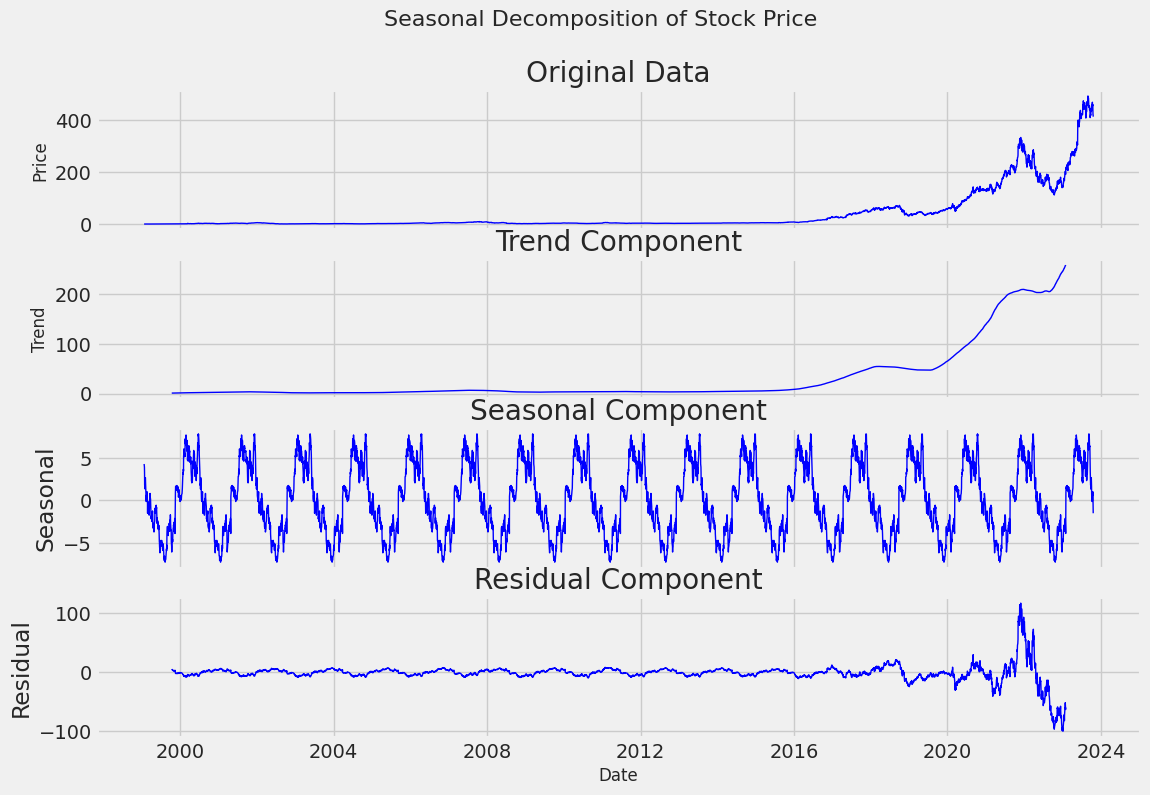

In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(data_arima['Close'], model='additive', period=365)

fig, axes = plt.subplots(4, 1, figsize=(12, 8), sharex=True)
fig.suptitle('Seasonal Decomposition of Stock Price', fontsize=16)

axes[0].set_title('Original Data')
axes[0].plot(data_arima['Close'], color='blue', linewidth = 1)
axes[0].set_ylabel('Price', fontsize=12)

axes[1].set_title('Trend Component')
axes[1].plot(result.trend, color='blue', linewidth = 1)
axes[1].set_ylabel('Trend', fontsize=12)

axes[2].set_title('Seasonal Component')
axes[2].plot(result.seasonal, color='blue', linewidth = 1)
axes[2].set_ylabel('Seasonal')

axes[3].set_title('Residual Component')
axes[3].plot(result.resid, color='blue', linewidth = 1)
axes[3].set_xlabel('Date', fontsize=12)
axes[3].set_ylabel('Residual')
plt.show()

## From the above, we can notice the following:
 - a clear positive trend
 - uniform seasonality (this resembles a sine wave)
 - the residual shows that the data from around 2021 onwards is no longer consistent and random


## Addressing the non-stationary, seasonality and trends
* Differencing
    * we will use try manual differencing to try to de-trend / de-season our data to make it stationary
    * here, I use pmdarima's ndiff function to identify how many orders of differencing I need to do a comparison as well
    * this is to compare with the auto arima model that will also perform the differencing for us. This is just a precautionary/validation step
* Scaling data: remove seasonality and trends
    * We will perform log-transformation and moving average to de-season and de-trend the data.
    * This will be part of our pre-processing step

## Exploring Differencing against Auto Arima

In [9]:
#pip install pmdarima

In [10]:
from pmdarima.arima.utils import ndiffs
ndiffs(data_arima['Close'], test = 'adf')

1

## Check for Stationarity again to see if the differencing worked
* I will perform the differencing
* I will perform another stationarity test to see if the differencing worked

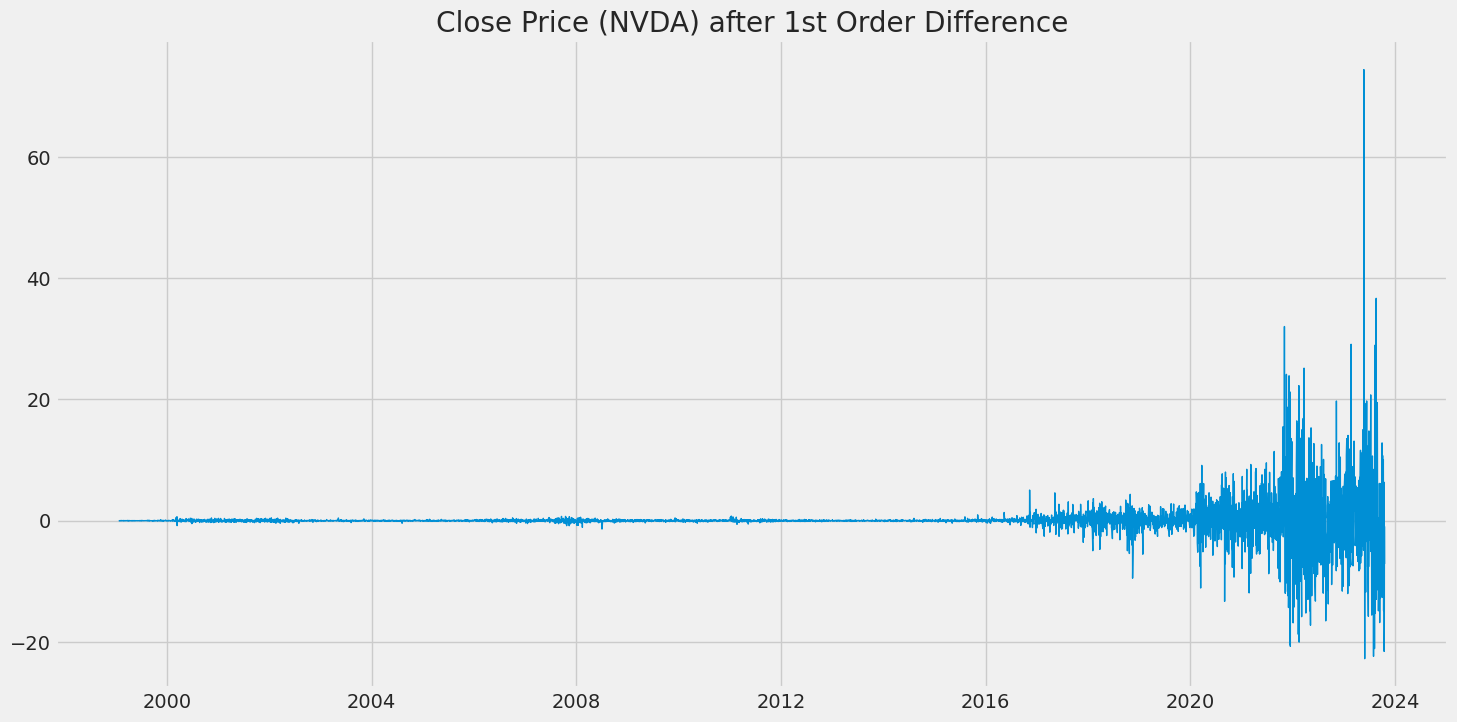

In [11]:
# only 1st Order differencing
data_arima['Close_diff'] = data_arima['Close'].diff()
data_arima['Close_diff'] = data_arima['Close_diff'].dropna()

#plot again to see if de-seasoned / de-trended
plt.figure(figsize=(16, 8))
plt.plot(data_arima['Close_diff'], linewidth = 1)
plt.title('Close Price (NVDA) after 1st Order Difference')
plt.show()

In [12]:
## perform Dickey-Fuller Test for stationarity again to check if stationary
result = adfuller(data_arima['Close_diff'].dropna())
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])
if result[1] <= 0.05:
    print('The data is stationary.')
else:
    print('The data is not stationary.')

ADF Statistic: -10.26369962014496
p-value: 4.172228129436024e-18
Critical Values: {'1%': -3.431406355974594, '5%': -2.8620068149070077, '10%': -2.5670184827348006}
The data is stationary.


<Figure size 1600x800 with 0 Axes>

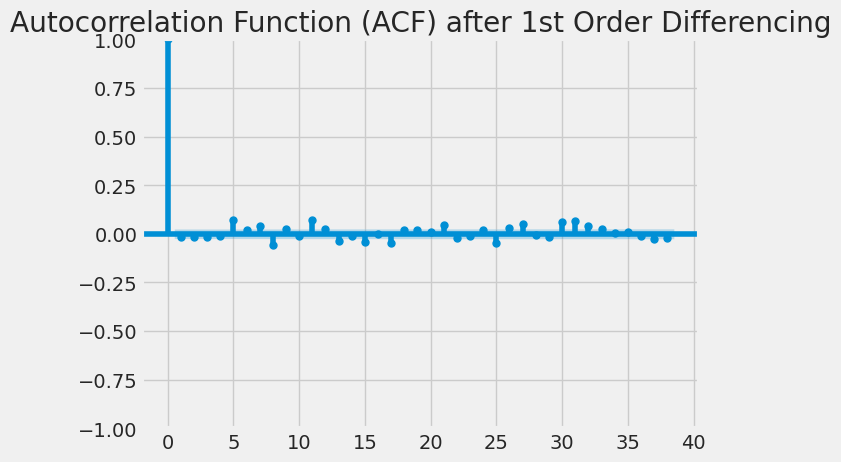

In [13]:
## and finally the acf plot for after 1st order differencing
plt.figure(figsize=(16, 8))
plot_acf(data_arima['Close_diff'].dropna())
plt.title('Autocorrelation Function (ACF) after 1st Order Differencing')
plt.show()

<Figure size 1600x800 with 0 Axes>

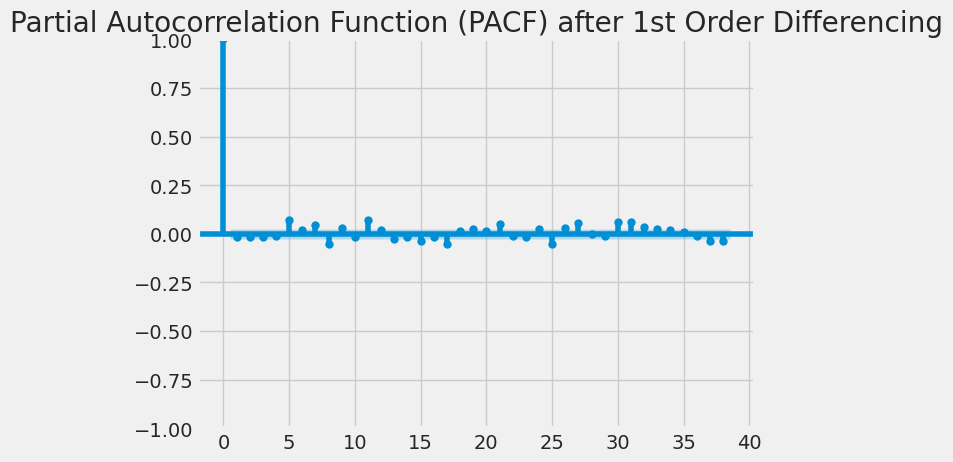

In [14]:
from statsmodels.graphics.tsaplots import plot_pacf

# Create the PACF plot after 1st order differencing
plt.figure(figsize=(16, 8))
plot_pacf(data_arima['Close_diff'].dropna())
plt.title('Partial Autocorrelation Function (PACF) after 1st Order Differencing')
plt.show()

## Considering how the plots looks, I chose to explore further differencing just to see if there was anything wrong
* theoretically, we could stop here since the data has shown stationarity

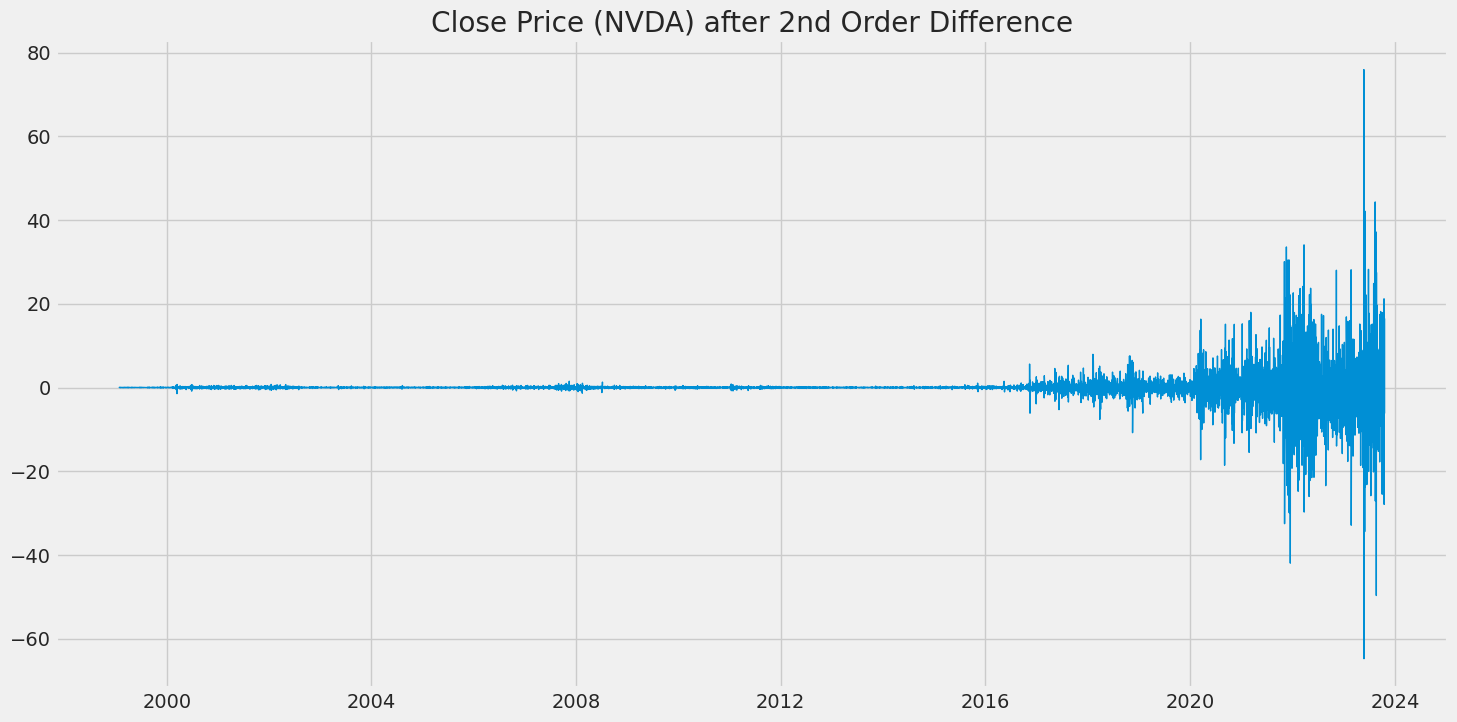

In [15]:
#plot again to see if de-seasoned / de-trended
data_arima['Close_diff2'] = data_arima['Close_diff'].diff()

plt.figure(figsize=(16, 8))
plt.plot(data_arima['Close_diff2'].dropna(), linewidth = 1)
plt.title('Close Price (NVDA) after 2nd Order Difference')
plt.show()

In [16]:
## perform Dickey-Fuller Test for stationarity again to check if stationary after 2nd order differencing
result = adfuller(data_arima['Close_diff2'].dropna())
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])
if result[1] <= 0.05:
    print('The data is stationary.')
else:
    print('The data is not stationary.')

ADF Statistic: -26.08748862668473
p-value: 0.0
Critical Values: {'1%': -3.4314065266455214, '5%': -2.862006890314898, '10%': -2.567018522876271}
The data is stationary.


<Figure size 1600x800 with 0 Axes>

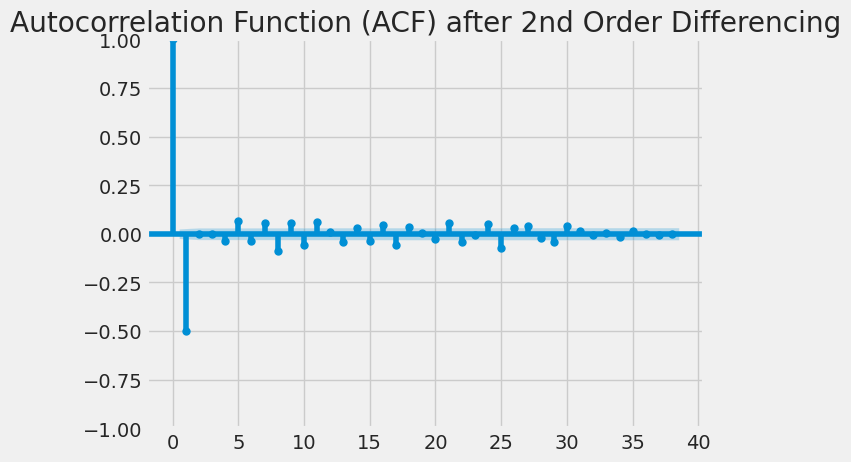

In [17]:
## and finally the acf plot for after 2nd order differencing
plt.figure(figsize=(16, 8))
plot_acf(data_arima['Close_diff2'].dropna())
plt.title('Autocorrelation Function (ACF) after 2nd Order Differencing')
plt.show()

<Figure size 1600x800 with 0 Axes>

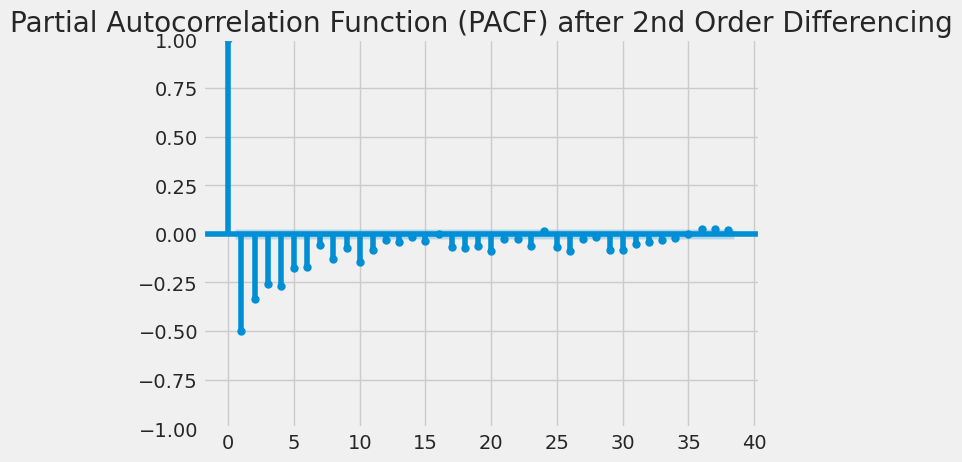

In [18]:
# Create the PACF plot after 2nd order differencing
plt.figure(figsize=(16, 8))
plot_pacf(data_arima['Close_diff2'].dropna())
plt.title('Partial Autocorrelation Function (PACF) after 2nd Order Differencing')
plt.show()

## Use Auto Arima to find the best parameters
* i will use the auto_arima function to find the best parameters
* this includes the number of differencing required

In [19]:
import pmdarima as pm

dataset = data_arima.dropna()
model = pm.auto_arima(dataset['Close'], m=12, seasonal=True, start_p=0, start_q=0, max_order=4, test='adf',error_action='ignore', suppress_warnings=True, stepwise=True, trace=True)
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=30702.812, Time=12.97 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=30703.309, Time=0.26 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=30702.284, Time=6.82 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=30702.363, Time=6.32 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=30704.692, Time=0.18 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=30704.004, Time=0.91 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=30702.278, Time=12.19 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=30702.413, Time=37.99 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=30703.427, Time=9.92 sec
 ARIMA(0,1,0)(2,0,0)[12] intercept   : AIC=30701.527, Time=7.01 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=30701.740, Time=2.30 sec
 ARIMA(0,1,0)(2,0,1)[12] intercept   : AIC=30701.526, Time=29.61 sec
 ARIMA(0,1,0)(2,0,2)[12] intercept   : AIC=inf, Time=72.62 sec
 ARIMA(0,1,0)(1,0,2)[12] intercept   : AIC=30701.598, Time=34.07 sec
 ARIM

## From the above, it is confirmed that our closing price only needs 1st order
 - p (Autoregressive order): 0, meaning there are no direct dependencies on past values.
 - d (Differencing order): 1, indicating one round of differencing for stationarity.
 - q (Moving Average order): 0, meaning no modeled correlations with past forecast errors.

## The auto arima also detected that there is seasonality (2,0,1):
 - Two seasonal autoregressive (SAR) terms.
 - No seasonal differencing (D).
 - One seasonal moving average (SMA) term.

## From the above, it shows that the ARIMA model is a simple one and our conclusion on first order differencing is correct and sufficient
* we will conduct use sarimax considering the (2, 0, 1) result from auto arima
* we could explore the use of log-transform which also helps to deseason the data but SARIMAX will also be suitable to perform the deseasoning for us


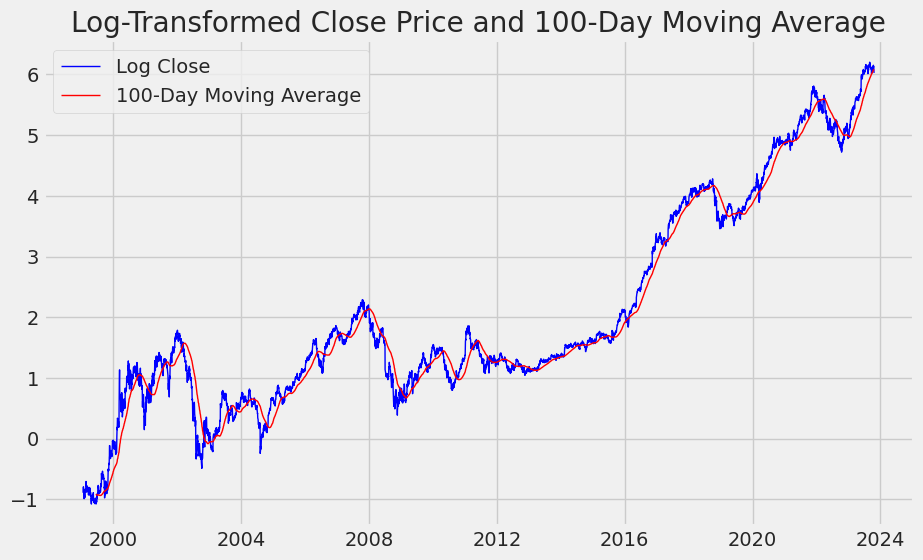

In [20]:
# log transform
data_arima['Log_Close'] = np.log(data_arima['Close'])

# Calculate 100-Day Moving Average
window_size = 100
data_arima['100-Day Moving_Avg'] = data_arima['Log_Close'].rolling(window=window_size).mean()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(data_arima['Log_Close'], label='Log Close', color='blue', linewidth = 1)
plt.plot(data_arima['100-Day Moving_Avg'], label='100-Day Moving Average', color='red', linewidth = 1)
plt.legend()
plt.title('Log-Transformed Close Price and 100-Day Moving Average')
plt.show()

## From above we can see how we can deseason data using log-transform

## We will split the data into test and training for the model to train and evaluate

In [21]:
cut_off = 60 # this indicates we want to predict 60 days in the future, for testing purpose

train_log = data_arima["Log_Close"].dropna().iloc[:-cut_off]
test_log = data_arima["Log_Close"].dropna().iloc[-cut_off:]

## index of the dates before/after the cut_off
train_idx = data_arima.index <= train_log.index[-1]
test_idx = data_arima.index > train_log.index[-1]

In [22]:
train = data_arima["Close"].dropna().iloc[:-cut_off]
test = data_arima["Close"].dropna().iloc[-cut_off:]

## We start to fit our ARIMA Model wih (0,1,0) using the log-transformed data
* the (0, 1, 0) is random walk...

## We will train both an ARIMA model with log-transformed and a SARIMAX Model with normal data to compare the results

In [23]:
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
import time

start_time = time.time()
model_arima = ARIMA(train_log, order=(0, 1, 0))
model_arima = model_arima.fit()
end_time = time.time()
train_time_arima = end_time - start_time

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [45]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

start_time = time.time()
model_sarimax = SARIMAX(train, order=(0, 1, 0), seasonal_order = (2, 0, 1, 12))
model_sarimax = model_sarimax.fit()
end_time = time.time()
train_time_sarimax = end_time - start_time

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


## Plotting predicted with actual
 * We will perform a reverse log-transformation on the forecasted results before plotting with the actual for the ARIMA model
 * Below is the plot of the forecast values of the SARIMAX model and the ARIMA model

## ARIMA model with log-transformed data

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Text(0.5, 1.0, 'Forecasted Closing Price of ARIMA Model')

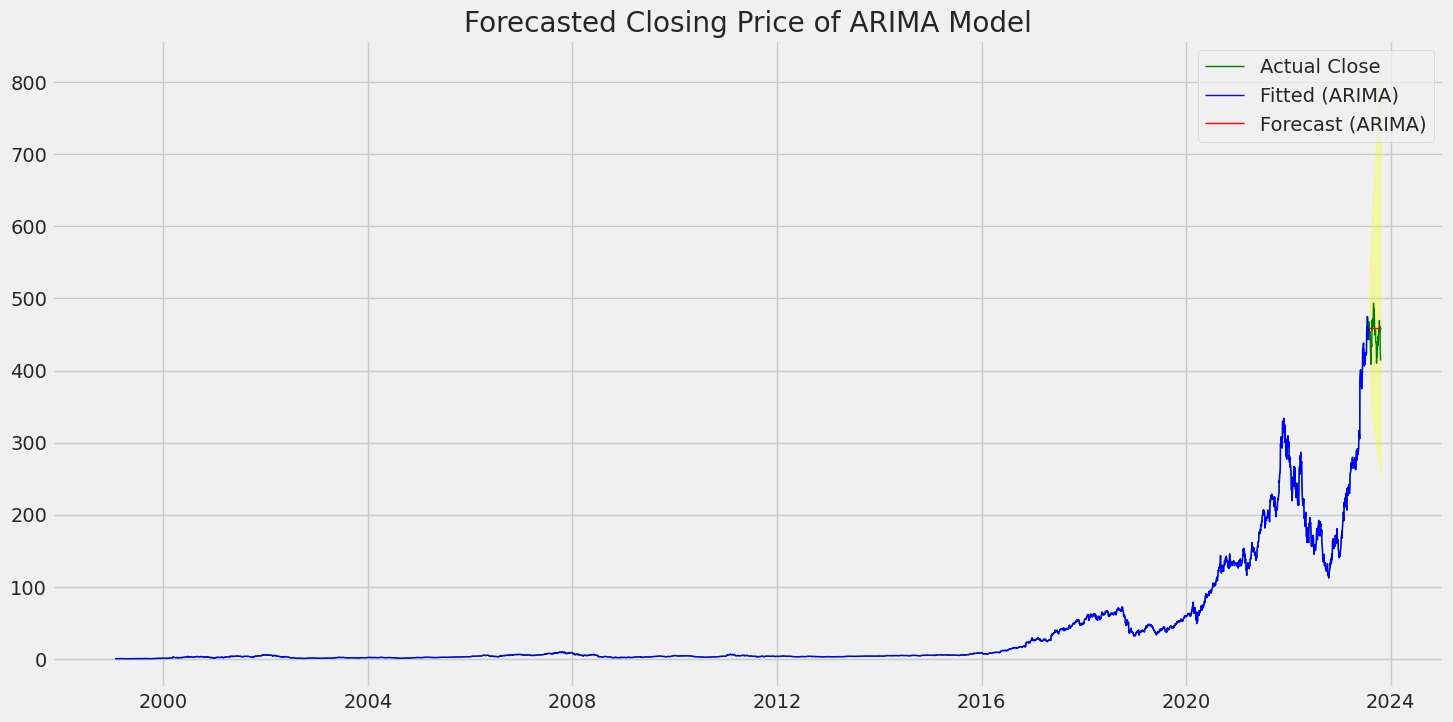

In [46]:
fig, ax = plt.subplots(figsize=(16, 8))
ax.plot(data_arima["Close"].dropna(), label='Actual Close', linewidth=1, color='green')

# Plotting the fitted values of the ARIMA model (training data)
ax.plot(train.index, data_arima["Close"].dropna().iloc[:-cut_off], color='blue', label='Fitted (ARIMA)', linewidth=1)

# Get the forecast values of the ARIMA model and reverse log
prediction_res = model_arima.get_forecast(cut_off)
forecast_arima = np.exp(prediction_res.predicted_mean)  # Reverse log transformation
ax.plot(test.index, forecast_arima, label='Forecast (ARIMA)', linewidth=1, color='red')

# Confidence interval of the ARIMA model
conf_int = prediction_res.conf_int()
lower = np.exp(conf_int[conf_int.columns[0]])  # Reverse log transformation
upper = np.exp(conf_int[conf_int.columns[1]])  # Reverse log transformation
ax.fill_between(test.index, lower, upper, color='yellow', alpha=0.3)

ax.legend()
ax.set_title('Forecasted Closing Price of ARIMA Model')

## Zoomed in for better visualisation (ARIMA)

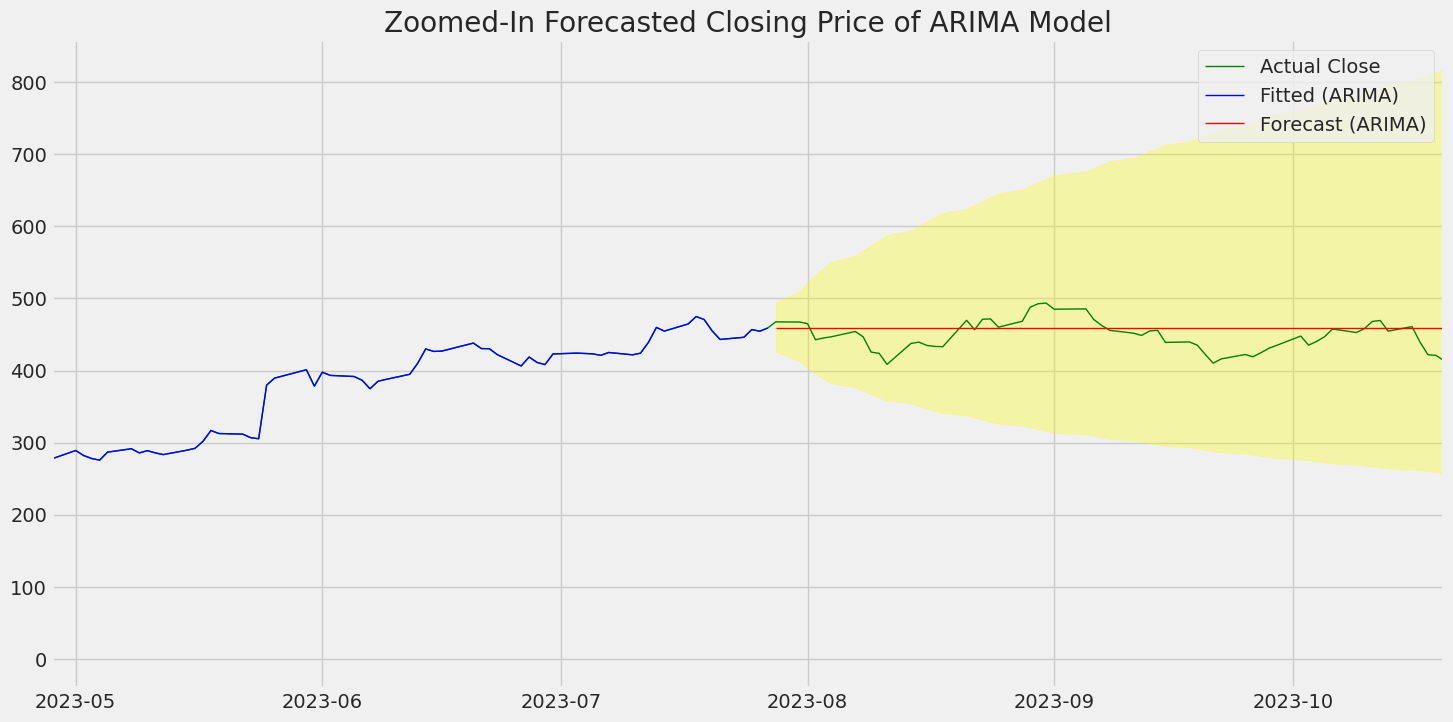

In [47]:
fig, ax = plt.subplots(figsize=(16, 8))
ax.plot(data_arima["Close"].dropna(), label='Actual Close', linewidth=1, color='green')
ax.plot(train.index, data_arima["Close"].dropna().iloc[:-cut_off], label='Fitted (ARIMA)', linewidth=1, color='blue')
ax.plot(test.index, forecast_arima, label='Forecast (ARIMA)', linewidth=1, color='red')
ax.fill_between(test.index, lower, upper, color='yellow', alpha=0.3)
ax.legend()
ax.set_title('Zoomed-In Forecasted Closing Price of ARIMA Model')
ax.set_xlim([test.index[0] - pd.DateOffset(months=3), test.index[-1]])
plt.show()

## Now for the SARIMAX Model

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Text(0.5, 1.0, 'Forecasted Closing Price of SARIMAX Model')

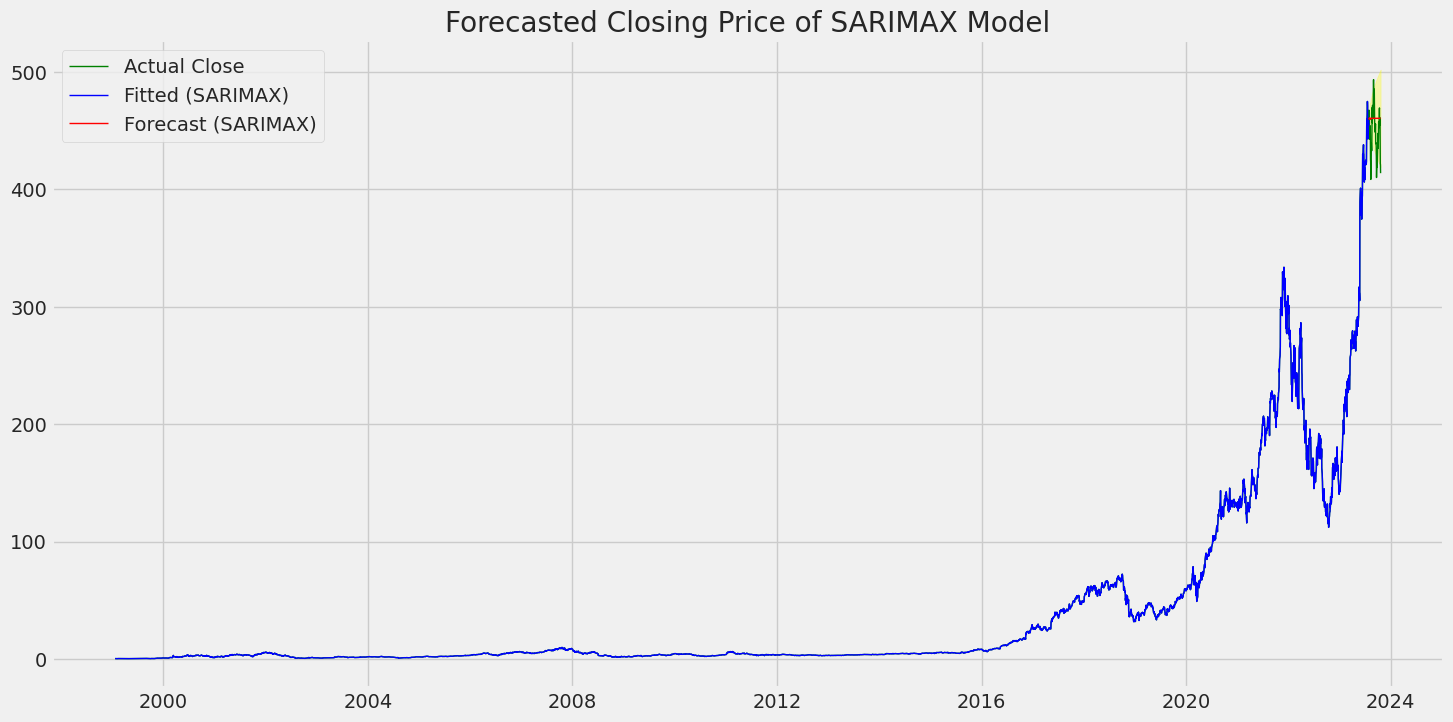

In [48]:
fig, ax = plt.subplots(figsize=(16, 8))
ax.plot(data_arima["Close"], label='Actual Close', linewidth=1, color='green')

# Plotting the fitted values of the SARIMAX model (training data)
ax.plot(train.index, data_arima["Close"].dropna().iloc[:-cut_off], color='blue', label='Fitted (SARIMAX)', linewidth=1)

# Get the forecast values of the SARIMAX model (predictions/forecast of model)
forecast_sarimax = model_sarimax.get_forecast(steps=cut_off)

# Mean of forecast
forecast_mean = forecast_sarimax.predicted_mean
ax.plot(test.index, forecast_mean, label='Forecast (SARIMAX)', linewidth=1, color='red')

# Confidence intervals of the model
conf_int = forecast_sarimax.conf_int()
lower = conf_int[conf_int.columns[0]]
upper = conf_int[conf_int.columns[1]]
ax.fill_between(test.index, lower, upper, color='yellow', alpha=0.3)

ax.legend()
ax.set_title('Forecasted Closing Price of SARIMAX Model')

## Zoomed in for better visualisation (SARIMAX)

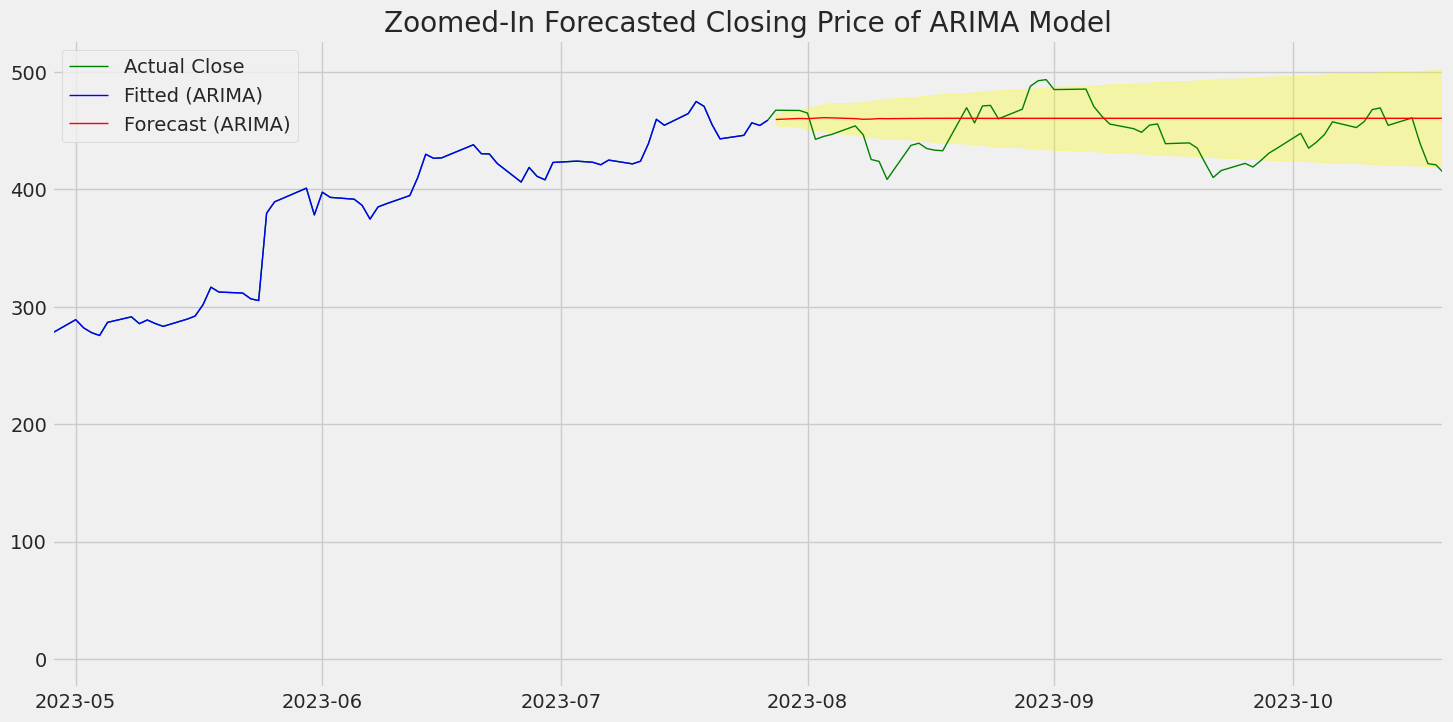

In [49]:
fig, ax = plt.subplots(figsize=(16, 8))
ax.plot(data_arima["Close"].dropna(), label='Actual Close', linewidth=1, color='green')
ax.plot(train.index, data_arima["Close"].dropna().iloc[:-cut_off], label='Fitted (ARIMA)', linewidth=1, color='blue')
ax.plot(test.index, forecast_mean, label='Forecast (ARIMA)', linewidth=1, color='red')
ax.fill_between(test.index, lower, upper, color='yellow', alpha=0.3)
ax.legend()
ax.set_title('Zoomed-In Forecasted Closing Price of ARIMA Model')
ax.set_xlim([test.index[0] - pd.DateOffset(months=3), test.index[-1]])
plt.show()

## As we can see from both plots, the forecasted value is a straight line.
 * The auto arima aligns with our own analysis of only needing first order differening, it is likely the auto arima accurately predicts the parameters for the dataset.
 * The forecasted value in the plot is a straight line, which aligns with our initial analysis. It indicates that the Auto ARIMA model accurately predicted the dataset's parameters.
 * The ARIMA(0,1,0) component of the model implies that NVDA's closing price follows a random walk. In simpler terms, it suggests that the data becomes stationary after a single differencing operation, making the differenced series resemble a white noise process.
 * There is not much visible difference in the SARIMAX model where de-seasoning and differencing is done for us and the ARIMA model using log-transformation to deseason.

## Now we want to evaluate our ARIMA model

In [50]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

# Evaluate ARIMA Model
y_true_arima = data_arima['Close'].dropna().iloc[-cut_off:].values
rmse_ARIMA = np.sqrt(mean_squared_error(y_true_arima, forecast_arima))
mae_ARIMA = mean_absolute_error(y_true_arima, forecast_arima)
print('ARIMA Model:')
print('Root Mean Squared Error (RMSE): ', rmse_ARIMA)
print('Mean Absolute Error (MAE): ', mae_ARIMA)

# Evaluate SARIMAX Model
y_true_sarimax = data_arima['Close'].dropna().iloc[-cut_off:].values
rmse_SARIMAX = np.sqrt(mean_squared_error(y_true_sarimax, forecast_mean))
mae_SARIMAX = mean_absolute_error(y_true_sarimax, forecast_mean)
print('SARIMAX Model:')
print('Root Mean Squared Error (RMSE): ', rmse_SARIMAX)
print('Mean Absolute Error (MAE): ', mae_SARIMAX)

ARIMA Model:
Root Mean Squared Error (RMSE):  23.4828111971647
Mean Absolute Error (MAE):  19.231666564941424
SARIMAX Model:
Root Mean Squared Error (RMSE):  24.234845949902816
Mean Absolute Error (MAE):  19.889888023084428



## The RMSE of the ARIMA model with manual de-seasoning is 23.48
## The RMSE of the SARIMAX model using auto-deseasoning is 24.23


In [51]:
import pandas as pd

model_performance = pd.DataFrame(columns=['MAE', 'RMSE', 'Train-time (secs)'])
model_performance.loc['ARIMA (0, 1, 0)'] = [mae_ARIMA, rmse_ARIMA, train_time_arima]
model_performance.loc['SARIMAX (0, 1, 0)(2, 0, 1)'] = [mae_SARIMAX, rmse_SARIMAX, train_time_sarimax]
model_performance.style.background_gradient(cmap='RdYlBu_r').format({'MAE': '{:.2f}', 'RMSE': '{:.2f}', 'Train-time (secs)': '{:.2f}'})

,MAE,RMSE,Train-time (secs)
"ARIMA (0, 1, 0)",19.23,23.48,0.28
"SARIMAX (0, 1, 0)(2, 0, 1)",19.89,24.23,2.79


# Conclusion
The implementation 2 of the time series model utilized traditional time series model of SARIMAX and ARIMA with manual de-seasoning due to the seasonality detected by auto arima. Both models are pretty similar in terms of performance

## ARIMA
For the both models, only historical closing price was used to predict the future stock price of NVDA. The model had also concluded that the direction and movement of NVDA stock price was essentially random walk and this make's it difficult to predict stock price. This is inline with our conclusion on the potential short comings of the LSTM model and any ML model when it is used in the context of stock price prediction.

## This portion is used for predicting the closing price of NVDA for 25th October to 7th November

In [52]:
## using the full historical data to train ARIMA model with log-transformation
actual_historical = data_arima["Log_Close"]

## training the model
actual_model = ARIMA(actual_historical, order=(0, 1, 0))
actual_model = actual_model.fit()

## making 14 days worth of predictions
actual_forecast = actual_model.get_forecast(steps=14)
actual_results = np.exp(actual_forecast.predicted_mean)
actual_results

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

6228    413.869995
6229    413.869995
6230    413.869995
6231    413.869995
6232    413.869995
6233    413.869995
6234    413.869995
6235    413.869995
6236    413.869995
6237    413.869995
6238    413.869995
6239    413.869995
6240    413.869995
6241    413.869995
Name: predicted_mean, dtype: float64

In [53]:
from datetime import datetime, timedelta

# Define the start date (October 25, 2023)
start_date = datetime(2023, 10, 25)

# dataframe formating for the data
date_range = [start_date + timedelta(days=i) for i in range(14)]

lst = []
for i in actual_results:
  lst.append(i)
# Convert the list of arrays to a DataFrame with date indices
final_df = pd.DataFrame(lst, index=date_range)
final_df.columns = ["Predicted Price for NVDA"]
final_df

,Predicted Price for NVDA
2023-10-25,413.869995
2023-10-26,413.869995
2023-10-27,413.869995
2023-10-28,413.869995
2023-10-29,413.869995
2023-10-30,413.869995
2023-10-31,413.869995
2023-11-01,413.869995
2023-11-02,413.869995
2023-11-03,413.869995


In [54]:
final_df.to_csv("Lee_Ee_Fun_Implementation_2(ARIMA)_predictions", index=False)